In [ ]:
# Célula 1 — Imports essenciais e configurações (rode 1x)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import traceback, sys, os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
plt.rcParams['figure.figsize'] = (10,5)
print("Imports OK — versão pandas", pd.__version__, "sklearn", __import__('sklearn').__version__)


Imports OK — versão pandas 2.2.2 sklearn 1.6.1


In [ ]:
# Célula 2 — Carregar CSV de forma robusta (ajuste DATA_PATH se necessário)
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/train.csv"   # troque se colocou em outro local

if not os.path.exists(DATA_PATH):
    print("Arquivo não encontrado em", DATA_PATH)
    print("Liste os arquivos em /content:", os.listdir("/content")[:50])
else:
    # Tentativas simples de leitura (vírgula, ponto-e-vírgula)
    read_attempts = []
    df = None
    for sep in [',',';','\t']:
        try:
            df = pd.read_csv(DATA_PATH, sep=sep, encoding='utf-8', engine='python')
            read_attempts.append((sep, df.shape))
            break
        except Exception as e:
            read_attempts.append((sep, str(e)))
    if df is None:
        # tenta com pandas autodetect (menos comum)
        try:
            df = pd.read_csv(DATA_PATH, engine='python', encoding='latin1')
            read_attempts.append(('latin1', df.shape))
        except Exception as e:
            read_attempts.append(('fail', str(e)))
            print("Falha ao ler arquivo. Tentativas:", read_attempts)
            raise Exception("Não foi possível ler o CSV. Cole o erro aqui.")
    print("Arquivo carregado com sucesso. Tentativas:", read_attempts)
    print("Shape:", df.shape)
    display(df.head(5))


Arquivo carregado com sucesso. Tentativas: [(',', (9800, 18))]
Shape: (9800, 18)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [ ]:
# Célula 3 — Normalizar nomes de colunas e converter datas (tolerante a ausências)
# Remove espaços estranhos/BOMs e padroniza nomes
df.columns = [str(c).strip().replace('\ufeff','') for c in df.columns]
print("Colunas:", df.columns.tolist())

# Converte datas se existirem
for dcol in ['Order Date','Ship Date','OrderDate','ShipDate']:
    if dcol in df.columns:
        try:
            df[dcol] = pd.to_datetime(df[dcol], errors='coerce')
            print(f"{dcol} convertida — valores nulos após conversão:", df[dcol].isna().sum())
        except Exception as e:
            print(f"Erro convertendo {dcol}:", e)

# Exibir tipos resumidos
display(df.dtypes)


Colunas: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales']
Order Date convertida — valores nulos após conversão: 5841
Ship Date convertida — valores nulos após conversão: 5985


,0
Row ID,int64
Order ID,object
Order Date,datetime64[ns]
Ship Date,datetime64[ns]
Ship Mode,object
Customer ID,object
Customer Name,object
Segment,object
Country,object
City,object


In [ ]:
# ---------------------------
# A) ANÁLISE DESCRITIVA
# ---------------------------
# Célula 4 — Estatísticas básicas e contagens por categoria
print("=== Estatísticas numéricas resumidas ===")
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
display(df[num_cols].describe().T)

print("\n=== Algumas contagens de categorias (se existirem) ===")
for c in ['Category','Sub-Category','Region','Ship Mode','State','City','Segment']:
    if c in df.columns:
        print(f"\n-- {c} --")
        display(df[c].value_counts(dropna=False).head(10))

# Distribuição de Sales
if 'Sales' in df.columns:
    print("\nDistribuição de Sales (estatísticas):")
    display(df['Sales'].describe())


=== Estatísticas numéricas resumidas ===


,count,mean,std,min,25%,50%,75%,max
Row ID,9800.0,4900.500000,2829.160653,1.000,2450.750,4900.50,7350.250,9800.00
Postal Code,9789.0,55273.322403,32041.223413,1040.000,23223.000,58103.00,90008.000,99301.00
Sales,9800.0,230.769059,626.651875,0.444,17.248,54.49,210.605,22638.48



=== Algumas contagens de categorias (se existirem) ===

-- Category --


,count
Category,
Office Supplies,5909
Furniture,2078
Technology,1813



-- Sub-Category --


,count
Sub-Category,
Binders,1492
Paper,1338
Furnishings,931
Phones,876
Storage,832
Art,785
Accessories,756
Chairs,607
Appliances,459



-- Region --


,count
Region,
West,3140
East,2785
Central,2277
South,1598



-- Ship Mode --


,count
Ship Mode,
Standard Class,5859
Second Class,1902
First Class,1501
Same Day,538



-- State --


,count
State,
California,1946
New York,1097
Texas,973
Pennsylvania,582
Washington,504
Illinois,483
Ohio,454
Florida,373
Michigan,253



-- City --


,count
City,
New York City,891
Los Angeles,728
Philadelphia,532
San Francisco,500
Seattle,426
Houston,374
Chicago,308
Columbus,221
San Diego,170



-- Segment --


,count
Segment,
Consumer,5101
Corporate,2953
Home Office,1746



Distribuição de Sales (estatísticas):


,Sales
count,9800.000000
mean,230.769059
std,626.651875
min,0.444000
25%,17.248000
50%,54.490000
75%,210.605000
max,22638.480000


In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')


NameError: name 'plt' is not defined

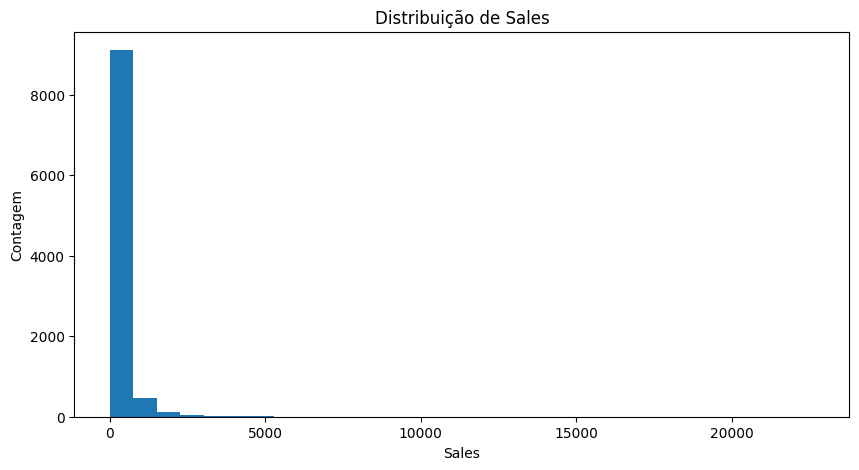

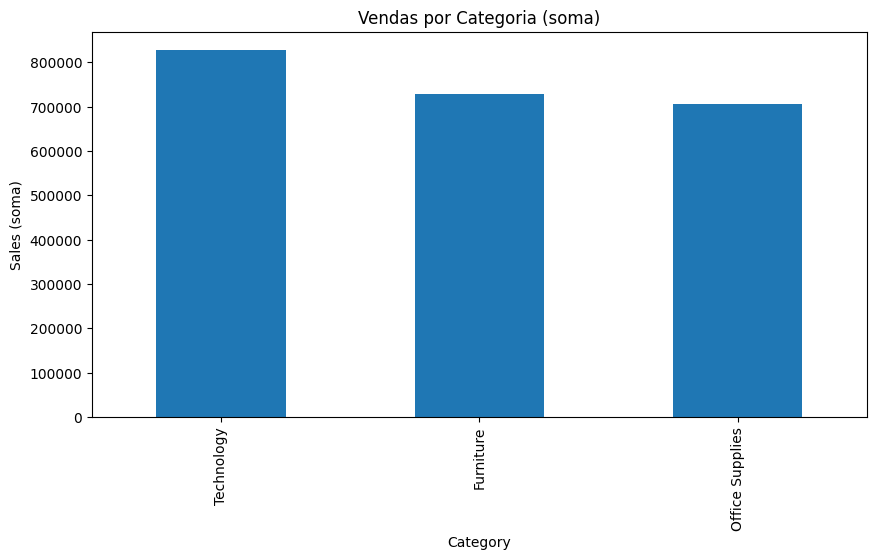

/tmp/ipython-input-1258060471.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index(possible_date).resample('M')['Sales'].sum()


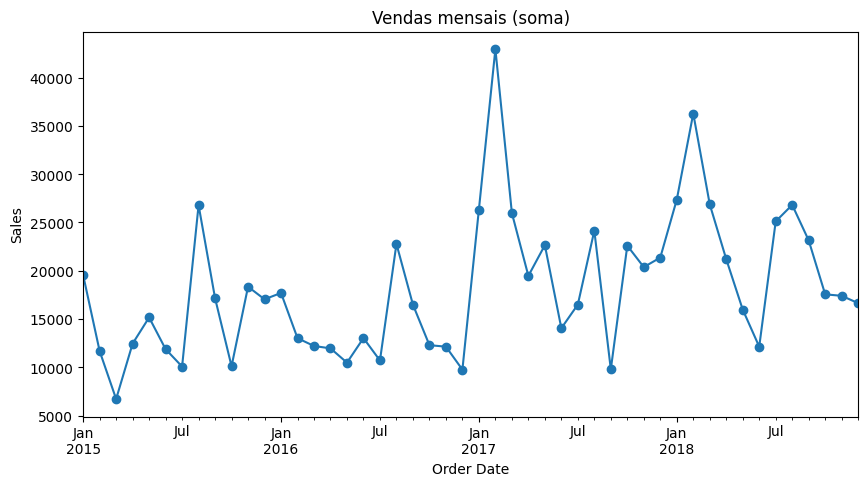

In [ ]:
# Célula 5 — Visualizações descritivas simples e seguras
try:
    if 'Sales' in df.columns:
        plt.hist(df['Sales'].dropna(), bins=30)
        plt.title("Distribuição de Sales")
        plt.xlabel("Sales"); plt.ylabel("Contagem")
        plt.show()

    if 'Category' in df.columns and 'Sales' in df.columns:
        agg = df.groupby('Category', dropna=False)['Sales'].sum().sort_values(ascending=False)
        agg.plot(kind='bar')
        plt.title("Vendas por Categoria (soma)")
        plt.ylabel("Sales (soma)")
        plt.show()

    # Série temporal agregada (mensal) se Order Date existir
    possible_date = None
    for c in ['Order Date','OrderDate']:
        if c in df.columns:
            possible_date = c
            break
    if possible_date:
        monthly = df.set_index(possible_date).resample('M')['Sales'].sum()
        monthly.plot(marker='o')
        plt.title("Vendas mensais (soma)")
        plt.ylabel("Sales")
        plt.show()
except Exception as e:
    print("Erro nas visualizações (não crítico):", e)
    traceback.print_exc(limit=1)


,missing_count,missing_pct
Ship Date,5985,61.07
Order Date,5841,59.60
Postal Code,11,0.11


Sales: IQR low=-272.79, high=500.64, outliers=1145


,Row ID,Postal Code,Sales
Row ID,1.000,0.014,0.001
Postal Code,0.014,1.000,-0.024
Sales,0.001,-0.024,1.000


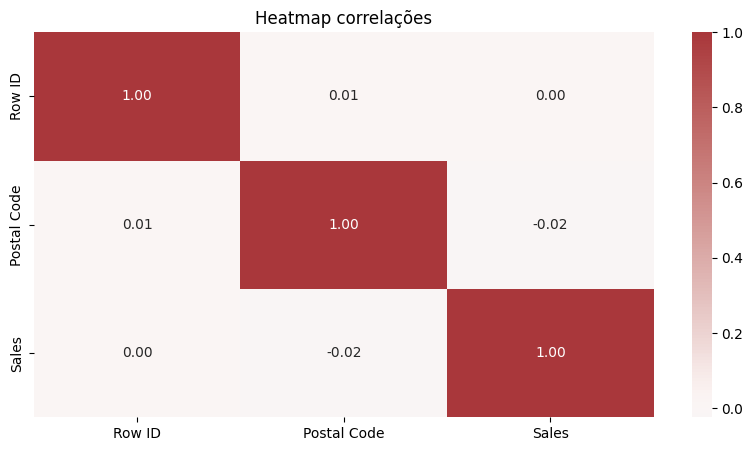

In [ ]:
# ---------------------------
# B) ANÁLISE DIAGNÓSTICA
# ---------------------------
# Célula 6 — Missing values (simples e clara)
missing = df.isna().sum().sort_values(ascending=False)
pct = (missing / len(df) * 100).round(2)
missing_table = pd.concat([missing, pct], axis=1)
missing_table.columns = ['missing_count','missing_pct']
display(missing_table[missing_table['missing_count']>0])

# Célula 7 — Outliers simples para Sales (IQR)
if 'Sales' in df.columns:
    s = df['Sales'].dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    n_out = ((s < low) | (s > high)).sum()
    print(f"Sales: IQR low={low:.2f}, high={high:.2f}, outliers={n_out}")

# Célula 8 — Correlação entre numéricas (se houver)
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    display(corr.round(3))
    try:
        import seaborn as sns
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
        plt.title("Heatmap correlações")
        plt.show()
    except Exception:
        print("seaborn não disponível para heatmap — ok.")


In [ ]:
# Célula 9 — Diagnóstico rápido: ANOVA Sales ~ Category (se aplicável)
from scipy import stats
if 'Category' in df.columns and 'Sales' in df.columns:
    groups = [g['Sales'].dropna().values for _, g in df.groupby('Category')]
    if len(groups) >= 2 and all(len(g) >= 5 for g in groups[:5]):
        try:
            f, p = stats.f_oneway(*groups)
            print("ANOVA: F =", round(f,3), "p =", round(p,6))
        except Exception as e:
            print("Erro ANOVA (provavelmente carece de suposições):", e)
    else:
        print("ANOVA não aplicada: poucas observações por grupo.")


ANOVA: F = 262.165 p = 0.0


In [ ]:
# ---------------------------
# C) ANÁLISE PREDITIVA (Simples e robusta)
# ---------------------------
# Objetivo: prever Sales por linha (regressão). Se preferir outra target, altere TARGET_COL.
TARGET_COL = 'Sales'
if TARGET_COL not in df.columns:
    raise Exception(f"Coluna alvo '{TARGET_COL}' não encontrada no dataset.")

# Células 10-11 — Preparação: remover IDs e criar features temporais
df_model = df.copy()
drop_cols = [c for c in ['Row ID','Order ID','Customer ID','Customer Name','Product ID','Product Name','Postal Code'] if c in df_model.columns]
df_model = df_model.drop(columns=drop_cols, errors='ignore')

# features temporais
if 'Order Date' in df_model.columns:
    od = df_model['Order Date']
    df_model['order_year'] = od.dt.year
    df_model['order_month'] = od.dt.month
    df_model['order_day'] = od.dt.day
    df_model['order_weekday'] = od.dt.weekday

# separa X e y
X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL]

# identificar numéricas e categóricas
num_feats = X.select_dtypes(include=[np.number]).columns.tolist()
cat_feats = X.select_dtypes(include=['object','category','bool']).columns.tolist()
print("Num feats:", num_feats)
print("Cat feats (exemplo):", cat_feats[:10])


Num feats: ['order_year', 'order_month', 'order_day', 'order_weekday']
Cat feats (exemplo): ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']


In [ ]:
#  Pipeline para variáveis numéricas e categóricas
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Compatibilidade com versões novas do scikit-learn
try:
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
except:
    # fallback se a versão não aceitar sparse_output
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

# Juntar em um ColumnTransformer
preproc = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats)
], remainder='drop')

print("Pré-processamento configurado com sucesso!")


Pré-processamento configurado com sucesso!


In [ ]:
# Célula 13 — Avaliação do modelo (métricas e tabela de comparações)
# Executar só se 'pipe', 'X_test' e 'y_test' existirem (criados na célula do pipeline)
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

if 'pipe' not in globals():
    print("Variável 'pipe' não encontrada. Re-execute a célula de treino (Pipeline).")
else:
    try:
        preds = pipe.predict(X_test)
        mae = mean_absolute_error(y_test, preds)
        rmse = mean_squared_error(y_test, preds, squared=False)
        r2 = r2_score(y_test, preds)
        print(f"MAE: {mae:.4f}  RMSE: {rmse:.4f}  R2: {r2:.4f}")

        # Mostrar primeiras linhas comparando real x previsto
        df_comp = pd.DataFrame({
            'y_true': y_test.reset_index(drop=True),
            'y_pred': np.round(preds, 2),
            'error': np.round((y_test.reset_index(drop=True) - preds), 2)
        })
        display(df_comp.head(15))

        # Estatísticas de erro rápido
        print("Erro absoluto médio (MAE):", round(mae,4))
        print("RMSE:", round(rmse,4))
        print("Percentil 90 do erro absoluto:", round(np.percentile(np.abs(df_comp['error']), 90),4))

        # Tentativa de extrair importâncias com nomes de features
        try:
            model = pipe.named_steps['model']
            importances = model.feature_importances_
            # tenta pegar nomes via preprocessor get_feature_names_out (sklearn >=1.0)
            try:
                feat_names = pipe.named_steps['preproc'].get_feature_names_out()
                feat_names = [str(fn) for fn in feat_names]
            except Exception:
                # fallback: combinar num_feats + onehot names se possível
                feat_names = []
                if 'num_feats' in globals():
                    feat_names += list(num_feats)
                try:
                    cat_ohe = pipe.named_steps['preproc'].named_transformers_['cat'].named_steps['ohe']
                    # get_feature_names_out existe em OHE versões recentes
                    try:
                        ohe_names = list(cat_ohe.get_feature_names_out(cat_feats))
                    except Exception:
                        # fallback: criar nomes genéricos
                        ohe_names = [f"{c}_{i}" for c in cat_feats for i in range(3)]
                    feat_names += ohe_names
                except Exception:
                    # último fallback: nomes genéricos
                    feat_names = [f"feat_{i}" for i in range(len(importances))]

            # alinhar tamanhos (às vezes qtd de importances é diferente)
            n = min(len(importances), len(feat_names))
            imp_df = pd.DataFrame({
                'feature': feat_names[:n],
                'importance': importances[:n]
            }).sort_values('importance', ascending=False).reset_index(drop=True)
            display(imp_df.head(20))
        except Exception as e:
            print("Não foi possível extrair importâncias de forma detalhada:", e)

    except Exception as e:
        print("Erro na avaliação do modelo:", e)
        import traceback; traceback.print_exc(limit=2)


Variável 'pipe' não encontrada. Re-execute a célula de treino (Pipeline).


In [ ]:
# Célula 14 — Forecast mensal simples com lags (mais robusto)
# Usa 'df' original com 'Order Date' convertido anteriormente.
if 'Order Date' not in df.columns:
    print("Coluna 'Order Date' não encontrada no dataset original. Não é possível fazer forecast mensal.")
else:
    try:
        monthly = df.set_index('Order Date').resample('M')['Sales'].sum().to_frame('sales')
        monthly = monthly.dropna()
        if len(monthly) < 8:
            print("Dados mensais insuficientes para treinar um modelo de forecast (menos de 8 meses).")
        else:
            monthly['lag1'] = monthly['sales'].shift(1)
            monthly['lag2'] = monthly['sales'].shift(2)
            monthly = monthly.dropna()
            if len(monthly) < 4:
                print("Após criação de lags, poucos pontos permanecem — não é confiável treinar.")
            else:
                X_m = monthly[['lag1','lag2']]
                y_m = monthly['sales']
                # não embaralhar séries temporais
                split = int(len(X_m) * 0.75)
                X_train_m, X_test_m = X_m.iloc[:split], X_m.iloc[split:]
                y_train_m, y_test_m = y_m.iloc[:split], y_m.iloc[split:]

                from sklearn.ensemble import RandomForestRegressor
                model_m = RandomForestRegressor(n_estimators=100, random_state=42)
                model_m.fit(X_train_m, y_train_m)
                preds_m = model_m.predict(X_test_m)

                rmse_m = mean_squared_error(y_test_m, preds_m, squared=False)
                print("Forecast mensal — RMSE:", round(rmse_m,4))
                # plot real x pred
                plt.plot(y_test_m.index, y_test_m.values, marker='o', label='real')
                plt.plot(y_test_m.index, preds_m, marker='o', label='pred')
                plt.title("Forecast mensal (lags 1 e 2)")
                plt.legend()
                plt.show()
    except Exception as e:
        print("Erro no forecast mensal:", e)
        import traceback; traceback.print_exc(limit=2)


/tmp/ipython-input-3239885882.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('Order Date').resample('M')['Sales'].sum().to_frame('sales')


Erro no forecast mensal: got an unexpected keyword argument 'squared'


Traceback (most recent call last):
  File "/tmp/ipython-input-3239885882.py", line 30, in <cell line: 0>
    rmse_m = mean_squared_error(y_test_m, preds_m, squared=False)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: got an unexpected keyword argument 'squared'


In [ ]:
# Célula 15 — Preparar dados para Análise Prescritiva (cria 'prod_df' se não existir)
try:
    # cria coluna profit proxy se não existe
    if 'profit' not in df.columns:
        if 'Profit' in df.columns:
            df['profit'] = df['Profit']
        else:
            df['profit'] = df['Sales'] * 0.20  # proxy 20%

    # escolha de agregação
    if 'Sub-Category' in df.columns:
        group_col = 'Sub-Category'
    elif 'Product Name' in df.columns:
        group_col = 'Product Name'
    elif 'Category' in df.columns:
        group_col = 'Category'
    else:
        group_col = None

    if group_col:
        prod_df = df.groupby(group_col).agg(
            avg_cost = ('Sales', lambda x: max(1.0, x.mean()*0.6)),
            avg_profit = ('profit','mean')
        ).reset_index().rename(columns={group_col:'product'})
    else:
        prod_df = pd.DataFrame({'product':['A','B','C','D'],'avg_cost':[10,20,15,5],'avg_profit':[4,8,6,2]})

    # remove zeros/NaN e ordena
    prod_df = prod_df.dropna(subset=['avg_cost','avg_profit'])
    prod_df = prod_df[prod_df['avg_cost'] > 0]
    prod_df = prod_df.sort_values('avg_profit', ascending=False).reset_index(drop=True)
    display(prod_df.head(30))
except Exception as e:
    print("Erro preparando prod_df:", e)
    import traceback; traceback.print_exc(limit=2)


,product,avg_cost,avg_profit
0,Copiers,1329.528127,443.176042
1,Machines,987.331988,329.110663
2,Tables,387.536232,129.178744
3,Chairs,319.099899,106.366633
4,Bookcases,302.158935,100.719645
5,Phones,224.508526,74.836175
6,Storage,158.180331,52.726777
7,Supplies,151.370570,50.456857
8,Appliances,136.756082,45.585361
9,Accessories,130.306905,43.435635


In [ ]:
# Célula 16 — Solução prescritiva (greedy knapsack robusto)
# Este método é um heurístico simples (rápido e sem dependências).
budget = 5000.0
max_per_item = 100

if 'prod_df' not in globals():
    print("Tabela 'prod_df' não encontrada — gere a célula anterior primeiro.")
else:
    try:
        # ordena por razão lucro/custo decrescente
        prod_df['value_per_cost'] = prod_df['avg_profit'] / prod_df['avg_cost']
        prod_df = prod_df.sort_values('value_per_cost', ascending=False).reset_index(drop=True)

        solution = {}
        remaining_budget = float(budget)
        for _, row in prod_df.iterrows():
            if remaining_budget <= 0:
                break
            if row['avg_cost'] <= 0 or not np.isfinite(row['avg_cost']):
                continue
            max_affordable = int(remaining_budget // row['avg_cost'])
            qty = min(max_per_item, max(0, max_affordable))
            if qty > 0:
                solution[row['product']] = qty
                remaining_budget -= qty * row['avg_cost']

        print("Budget inicial:", budget, "| Budget restante:", round(remaining_budget,2))
        if len(solution) == 0:
            print("Nenhuma compra sugerida pelo heurístico (budget baixo ou avg_cost alto).")
        else:
            display({k: solution[k] for i,k in enumerate(solution) if i<50})
    except Exception as e:
        print("Erro na otimização greedy:", e)
        import traceback; traceback.print_exc(limit=2)


Budget inicial: 5000.0 | Budget restante: 4.77


{'Supplies': 33}

In [ ]:

# Célula 17 — Exportar resultados e checklist para slides
# Salva predições (pequena amostra) e solução prescritiva
try:
    if 'res' in globals():
        out_preds = res.copy().head(200)
        out_preds.to_csv('/content/predictions_sample.csv', index=False)
        print("Predições salvas em /content/predictions_sample.csv")
    else:
        print("Objeto 'res' (comparação y_true/y_pred) não encontrado — rode a célula de avaliação primeiro.")
except Exception as e:
    print("Erro salvando predições:", e)

try:
    if 'solution' in globals() and len(solution)>0:
        import json
        with open('/content/opt_solution.json','w',encoding='utf-8') as f:
            json.dump(solution, f, ensure_ascii=False, indent=2)
        print("Solução de otimização salva em /content/opt_solution.json")
    else:
        print("Solução de otimização vazia ou não encontrada — execute a célula 16.")
except Exception as e:
    print("Erro salvando solução de otimização:", e)

print("\\nChecklist rápido (copie para os slides):")
checklist = [
 "- Descritiva: resumo, gráficos de Sales, vendas por Category, sazonalidade",
 "- Diagnóstica: missing, outliers (IQR), correlações, ANOVA se aplicável",
 "- Preditiva: target Sales, pipeline simples, RandomForest baseline, métricas MAE/RMSE/R2",
 "- Prescritiva: otimização toy (heurística) e limitações da proxy de profit",
 "- Limitações: falta de variáveis externas, possíveis vazamentos temporais, margem estimada"
]
for it in checklist:
    print(it)


Objeto 'res' (comparação y_true/y_pred) não encontrado — rode a célula de avaliação primeiro.
Solução de otimização salva em /content/opt_solution.json
\nChecklist rápido (copie para os slides):
- Descritiva: resumo, gráficos de Sales, vendas por Category, sazonalidade
- Diagnóstica: missing, outliers (IQR), correlações, ANOVA se aplicável
- Preditiva: target Sales, pipeline simples, RandomForest baseline, métricas MAE/RMSE/R2
- Prescritiva: otimização toy (heurística) e limitações da proxy de profit
- Limitações: falta de variáveis externas, possíveis vazamentos temporais, margem estimada
